In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter('ignore')
from sklearn.metrics.pairwise import euclidean_distances
import pyodbc

In [3]:
DB = {
    "servername" : r"VISSIE\SQLEXPRESS",
    "database" : "SDM"}

export_conn = pyodbc.connect(f"""DRIVER={'SQL SERVER'};
                             SERVER={DB['servername']};
                             DATABASE={DB['database']};
                             Trusted_Connection=yes
                             """)

export_conn.setencoding('utf-8')
export_conn.setdecoding(pyodbc.SQL_CHAR, encoding='utf-8')
export_conn.setdecoding(pyodbc.SQL_WCHAR, encoding='utf-8')

export_cursor = export_conn.cursor()

In [4]:
def create_dataframes_sql(connection, db_type : str):
    dictionary : dict = {}
    query : str = ""
    key : str = ""
    
    if (db_type == "sqlite"):
        query = "SELECT name FROM sqlite_master WHERE type='table';"
        key = "name"
    elif (db_type == "ssms"):
        query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE';"
        key = "TABLE_NAME"
    else:
        return {}
    table_names = pd.read_sql(query, connection)
    
    for table in table_names[key].tolist():
        dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)
    
    return dictionary

sdm = create_dataframes_sql(export_conn, "ssms")

In [5]:
orders = sdm["order_details"]

orders_specfic = orders[["QUANTITY", "UNIT_COST", "UNIT_PRICE", "UNIT_SALE_PRICE", "ORDER_NUMBER"]]
orders_specfic["TOTAL_COSTS"] = orders["QUANTITY"] * orders["UNIT_COST"]
orders_specfic["REVENUE"] = orders["QUANTITY"] * orders["UNIT_SALE_PRICE"]
orders_specfic["PROFIT"] = (orders["UNIT_PRICE"] * orders["QUANTITY"]) - orders_specfic["TOTAL_COSTS"]

frame = pd.merge(sdm["sales_branch"], sdm["order_header"], left_on="SALES_BRANCH_CODE", right_on="SALES_BRANCH_CODE")
frame = pd.merge(frame, sdm["order_details"], left_on="ORDER_NUMBER", right_on="ORDER_NUMBER")
frame = pd.merge(frame, sdm["product"], left_on="PRODUCT_NUMBER", right_on="PRODUCT_NUMBER")
frame = pd.merge(frame, sdm["country"], left_on="COUNTRY_CODE", right_on="COUNTRY_CODE", suffixes=("", "_drop"))
#frame = pd.merge(frame, orders_specfic, left_on="ORDER_NUMBER", right_on="ORDER_NUMBER", suffixes=("", "_drop"))

frame = frame[[col for col in frame.columns if not col.endswith("_drop")]]

#frame = frame[["SALES_BRANCH_CODE", "CITY", "COUNTRY", "QUANTITY", "PRODUCT_NAME", "UNIT_SALE_PRICE"]]
frame

,SALES_BRANCH_CODE,ADDRESS1,ADDRESS2,CITY,REGION,POSTAL_ZONE,COUNTRY_CODE,ORDER_NUMBER,RETAILER_NAME,RETAILER_SITE_CODE,...,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,COUNTRY,CURRENCY_NAME,FLAG_IMAGE,SALES_TERRITORY_CODE
0,6,"75, rue du Faubourg St-Honoré",None,Paris,None,F-75008,1,2259,ActiForme,196,...,65.330002,0.33,P23CE1SB3.jpg,EN,Hibernator Camp Cot,Aluminum frame camp cot that is lightweight an...,France,francs,F01,6
1,6,"75, rue du Faubourg St-Honoré",None,Paris,None,F-75008,1,2259,ActiForme,196,...,78.550003,0.28,P84PA3NV14.jpg,EN,Glacier GPS,"Global Positioning System that is small, light...",France,francs,F01,6
2,6,"75, rue du Faubourg St-Honoré",None,Paris,None,F-75008,1,2260,ActiForme,196,...,473.070007,0.23,P12CE1TN2.jpg,EN,Star Dome,Four pole geodesic dome mountain tent that com...,France,francs,F01,6
3,6,"75, rue du Faubourg St-Honoré",None,Paris,None,F-75008,1,2261,ActiForme,197,...,41.180000,0.40,P29CE1PK4.jpg,EN,Canyon Mule Carryall,"This pack has a large capacity, perfect for ca...",France,francs,F01,6
4,6,"75, rue du Faubourg St-Honoré",None,Paris,None,F-75008,1,2262,ActiForme,197,...,476.000000,0.20,P14CE1TN2.jpg,EN,Star Gazer 3,"The Star Gazer 3 features a water proof fly, m...",France,francs,F01,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37752,39,Jedleser Straße 7,None,Wien,None,A-1210,5,7470,Outdoor-Fachgeschõft M³ller,434,...,20.000000,0.50,P61ME2TL9.jpg,EN,Granite Axe,Camping axe with clear coated wood handle.,Austria,schillings,F05,7
37753,39,Jedleser Straße 7,None,Wien,None,A-1210,5,7470,Outdoor-Fachgeschõft M³ller,434,...,47.060001,0.40,P62ME2TL9.jpg,EN,Granite Extreme,The Edge Extreme is a collapsible plier-shaped...,Austria,schillings,F05,7
37754,39,Jedleser Straße 7,None,Wien,None,A-1210,5,7470,Outdoor-Fachgeschõft M³ller,434,...,40.000000,0.50,P81PA3BN13.jpg,EN,Seeker Mini,This 8 x 22 model is economical and performs w...,Austria,schillings,F05,7
37755,39,Jedleser Straße 7,None,Wien,None,A-1210,5,7470,Outdoor-Fachgeschõft M³ller,434,...,176.470001,0.40,P85PA3NV14.jpg,EN,Glacier GPS Extreme,Hand held GPS receiver with color display. Inc...,Austria,schillings,F05,7


In [6]:
#frame["SALES_BRANCH_CODE"] = frame["SALES_BRANCH_CODE"].astype(str)
frame.dtypes

SALES_BRANCH_CODE          int64
ADDRESS1                  object
ADDRESS2                  object
CITY                      object
REGION                    object
POSTAL_ZONE               object
COUNTRY_CODE               int64
ORDER_NUMBER               int64
RETAILER_NAME             object
RETAILER_SITE_CODE         int64
RETAILER_CONTACT_CODE      int64
SALES_STAFF_CODE           int64
ORDER_DATE                object
ORDER_METHOD_CODE          int64
ORDER_DETAIL_CODE          int64
PRODUCT_NUMBER             int64
QUANTITY                   int64
UNIT_COST                float64
UNIT_PRICE               float64
UNIT_SALE_PRICE          float64
INTRODUCTION_DATE         object
PRODUCT_TYPE_CODE          int64
PRODUCTION_COST          float64
MARGIN                   float64
PRODUCT_IMAGE             object
LANGUAGE                  object
PRODUCT_NAME              object
DESCRIPTION               object
COUNTRY                   object
CURRENCY_NAME             object
FLAG_IMAGE

In [7]:
dummies_city = pd.get_dummies(frame.loc[:, ["CITY", "COUNTRY"]])
dummies_city

dummie_frame = pd.get_dummies(frame.loc[:, ["CITY", "COUNTRY"]])

dummie_frame

,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,CITY_Hamburg,CITY_Heverlee,CITY_Kista,CITY_Kuopio,...,COUNTRY_Japan,COUNTRY_Korea,COUNTRY_Mexico,COUNTRY_Netherlands,COUNTRY_Spain,COUNTRY_Sweden,COUNTRY_Switzerland,COUNTRY_Taiwan,COUNTRY_United Kingdom,COUNTRY_United States
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37752,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37753,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37754,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37755,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
frame_2 = frame[["QUANTITY", "SALES_BRANCH_CODE"]]

frame_2


,QUANTITY,SALES_BRANCH_CODE
0,10,6
1,22,6
2,64,6
3,36,6
4,44,6
...,...,...
37752,64,39
37753,44,39
37754,28,39
37755,20,39


In [9]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit_predict(frame_2)

array([4, 4, 5, ..., 0, 0, 0], shape=(37757,), dtype=int32)

In [10]:
kmeans.cluster_centers_

array([[ 21.32264272,  33.71648493],
       [255.13489736,  20.58357771],
       [ 91.60342497,  21.18702118],
       [421.35087719,  22.06140351],
       [ 19.0837245 ,  16.3634036 ],
       [ 49.97699669,  22.22202797],
       [154.19739479,  20.41382766],
       [860.3030303 ,  25.3030303 ]])

In [11]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1
0,21.322643,33.716485
1,255.134897,20.583578
2,91.603425,21.187021
3,421.350877,22.061404
4,19.083725,16.363404
5,49.976997,22.222028
6,154.197395,20.413828
7,860.303030,25.303030


In [12]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{frame_2.columns[i]}'})
    
kmeans_centra

,QUANTITY,SALES_BRANCH_CODE
0,21.322643,33.716485
1,255.134897,20.583578
2,91.603425,21.187021
3,421.350877,22.061404
4,19.083725,16.363404
5,49.976997,22.222028
6,154.197395,20.413828
7,860.303030,25.303030


In [13]:
for src_index, _ in frame_2.iterrows():
    euclidian_distances = dict()
    #print(f"Afstand van bronindex {src_index} tot...")
    
    for centrumindex, _ in kmeans_centra.iterrows():
        #print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = frame_2.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            #print(f'\t\t{frame_2.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        #print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        #print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        #print('------------------------------------------------')
    
    #print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    #print(centrum_number)
    frame_2.at[src_index, 'Centrum'] = centrum_number
    #print("================================================")

frame_2

,QUANTITY,SALES_BRANCH_CODE,Centrum
0,10,6,4.0
1,22,6,4.0
2,64,6,5.0
3,36,6,4.0
4,44,6,5.0
...,...,...,...
37752,64,39,5.0
37753,44,39,5.0
37754,28,39,0.0
37755,20,39,0.0


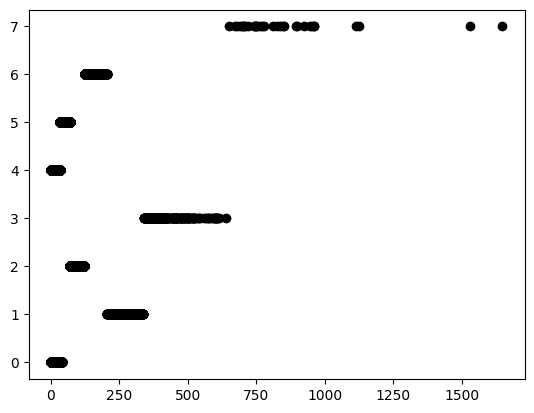

In [14]:
plt.scatter(frame_2['QUANTITY'], frame_2['Centrum'], color = 'k')
plt.show()

In [15]:
frame_2.groupby('Centrum', as_index = False)['Centrum'].count()

frame.dtypes

SALES_BRANCH_CODE          int64
ADDRESS1                  object
ADDRESS2                  object
CITY                      object
REGION                    object
POSTAL_ZONE               object
COUNTRY_CODE               int64
ORDER_NUMBER               int64
RETAILER_NAME             object
RETAILER_SITE_CODE         int64
RETAILER_CONTACT_CODE      int64
SALES_STAFF_CODE           int64
ORDER_DATE                object
ORDER_METHOD_CODE          int64
ORDER_DETAIL_CODE          int64
PRODUCT_NUMBER             int64
QUANTITY                   int64
UNIT_COST                float64
UNIT_PRICE               float64
UNIT_SALE_PRICE          float64
INTRODUCTION_DATE         object
PRODUCT_TYPE_CODE          int64
PRODUCTION_COST          float64
MARGIN                   float64
PRODUCT_IMAGE             object
LANGUAGE                  object
PRODUCT_NAME              object
DESCRIPTION               object
COUNTRY                   object
CURRENCY_NAME             object
FLAG_IMAGE

In [16]:
kmeans = KMeans(n_clusters = 25, random_state = 42)
prediction_results = kmeans.fit_predict(dummie_frame)
prediction_results

array([6, 6, 6, ..., 7, 7, 7], shape=(37757,), dtype=int32)

In [17]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)

#Interclusterafstanden weergeven.
#Intraclusterafstanden: zelf ChatGPT'en
dists = euclidean_distances(kmeans.cluster_centers_)
pd.DataFrame(dists)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000,1.893752,1.893752,1.893752,1.787351,1.893752,1.893752,1.893752,1.893752,1.893752,...,1.259483,1.893752,1.893752,1.893752,1.893752,1.893752,1.893752,1.893752,1.893752,1.893752
1,1.893752,0.000000,2.000000,2.000000,1.899559,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
2,1.893752,2.000000,0.000000,2.000000,1.899559,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.414214,2.000000,2.000000,2.000000
3,1.893752,2.000000,2.000000,0.000000,1.899559,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
4,1.787351,1.899559,1.899559,1.899559,0.000000,1.899559,1.899559,1.899559,1.899559,1.899559,...,1.899559,1.899559,1.899559,1.899559,1.899559,1.899559,1.899559,1.899559,1.899559,1.899559
5,1.893752,2.000000,2.000000,2.000000,1.899559,0.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
6,1.893752,2.000000,2.000000,2.000000,1.899559,2.000000,0.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.414214
7,1.893752,2.000000,2.000000,2.000000,1.899559,2.000000,2.000000,0.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
8,1.893752,2.000000,2.000000,2.000000,1.899559,2.000000,2.000000,2.000000,0.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.414214,2.000000,2.000000,2.000000,2.000000
9,1.893752,2.000000,2.000000,2.000000,1.899559,2.000000,2.000000,2.000000,2.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [18]:
frame['Centrum'] = prediction_results
frame

,SALES_BRANCH_CODE,ADDRESS1,ADDRESS2,CITY,REGION,POSTAL_ZONE,COUNTRY_CODE,ORDER_NUMBER,RETAILER_NAME,RETAILER_SITE_CODE,...,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,COUNTRY,CURRENCY_NAME,FLAG_IMAGE,SALES_TERRITORY_CODE,Centrum
0,6,"75, rue du Faubourg St-Honoré",None,Paris,None,F-75008,1,2259,ActiForme,196,...,0.33,P23CE1SB3.jpg,EN,Hibernator Camp Cot,Aluminum frame camp cot that is lightweight an...,France,francs,F01,6,6
1,6,"75, rue du Faubourg St-Honoré",None,Paris,None,F-75008,1,2259,ActiForme,196,...,0.28,P84PA3NV14.jpg,EN,Glacier GPS,"Global Positioning System that is small, light...",France,francs,F01,6,6
2,6,"75, rue du Faubourg St-Honoré",None,Paris,None,F-75008,1,2260,ActiForme,196,...,0.23,P12CE1TN2.jpg,EN,Star Dome,Four pole geodesic dome mountain tent that com...,France,francs,F01,6,6
3,6,"75, rue du Faubourg St-Honoré",None,Paris,None,F-75008,1,2261,ActiForme,197,...,0.40,P29CE1PK4.jpg,EN,Canyon Mule Carryall,"This pack has a large capacity, perfect for ca...",France,francs,F01,6,6
4,6,"75, rue du Faubourg St-Honoré",None,Paris,None,F-75008,1,2262,ActiForme,197,...,0.20,P14CE1TN2.jpg,EN,Star Gazer 3,"The Star Gazer 3 features a water proof fly, m...",France,francs,F01,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37752,39,Jedleser Straße 7,None,Wien,None,A-1210,5,7470,Outdoor-Fachgeschõft M³ller,434,...,0.50,P61ME2TL9.jpg,EN,Granite Axe,Camping axe with clear coated wood handle.,Austria,schillings,F05,7,7
37753,39,Jedleser Straße 7,None,Wien,None,A-1210,5,7470,Outdoor-Fachgeschõft M³ller,434,...,0.40,P62ME2TL9.jpg,EN,Granite Extreme,The Edge Extreme is a collapsible plier-shaped...,Austria,schillings,F05,7,7
37754,39,Jedleser Straße 7,None,Wien,None,A-1210,5,7470,Outdoor-Fachgeschõft M³ller,434,...,0.50,P81PA3BN13.jpg,EN,Seeker Mini,This 8 x 22 model is economical and performs w...,Austria,schillings,F05,7,7
37755,39,Jedleser Straße 7,None,Wien,None,A-1210,5,7470,Outdoor-Fachgeschõft M³ller,434,...,0.40,P85PA3NV14.jpg,EN,Glacier GPS Extreme,Hand held GPS receiver with color display. Inc...,Austria,schillings,F05,7,7


In [19]:
frame.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,2939
1,2514
2,1468
3,3451
4,2316
5,2020
6,1173
7,1730
8,1115
9,1395
